<h1>프로젝트: 고양이 수염 스티커 만들기<h1>

필요한 라이브러리 import

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, time
import dlib

이미지 준비

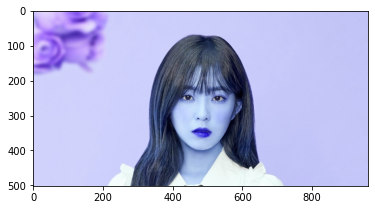

img_size :  (502, 960, 3)


In [2]:
img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/image.png'
#img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/ley.jpeg'
#img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/IMG_1314.jpg'
#img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/IMG_1315.jpg'
img_bgr = cv2.imread(img_path)  #- OpenCV로 이미지를 읽어서
#img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()  # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_bgr)
plt.show()
print('img_size : ', img_rgb.shape)

얼굴 검출 & 랜드마크 검출 하기

rectangles[[(386, 201) (572, 387)]]


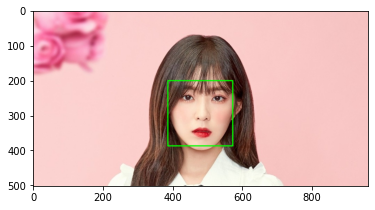

In [3]:
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top() 
    r = dlib_rect.right()
    b = dlib_rect.bottom()

cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 녹색으로

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

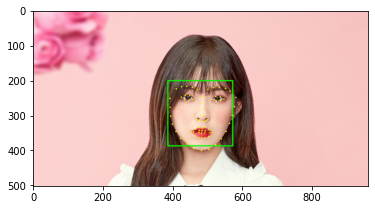

In [4]:
# 저장한 landmark 모델을 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 개별 위치에 접근하여 (x,y)형태로 변환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# check - face landmark
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)  # yellow
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

스티커 적용 위치 확인하기

In [5]:
# 코의 좌표 확인 및 스티커의 위치 지정
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # print(landmark[30])  # nose center index (187, 367)
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print('x, y, w, h : ', x, y, w, h)

# 3-2. 스티커 이미지 사이즈 수정
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))  # (322, 322, 3)
print(f'스티커 사이즈 : {img_sticker.shape}')

# 3-3. 스티커 이미지의 x,y좌표 조정. 이미지의 시작점은 top-left이기때문에.
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print(f'(refined_x, refined_y) : ({refined_x}, {refined_y})')  # (109, 65)

x, y, w, h :  485 300 187 187
스티커 사이즈 : (187, 187, 3)
(refined_x, refined_y) : (392, 207)


스티커 적용하기

sticker area :  (187, 187, 3)


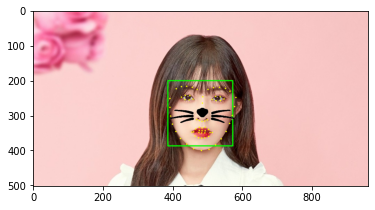

In [6]:
#스티커가 이미지를 벗어날 경우 잘라주기
if refined_x + w > img_show.shape[1]:  # 오른쪽으로 벗어날 경우
    img_sticker = img_sticker[:, :img_show.shape[1]-(refined_x+w)]
elif refined_x < 0:                    # 왼쪽으로 벗어날 경우
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

# 스티커 이미지 영역 잡아주기
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print('sticker area : ', sticker_area.shape)

#스티커를 이미지에 적용하기
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] \
    = np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

바운딩 박스와 랜드마크 제거

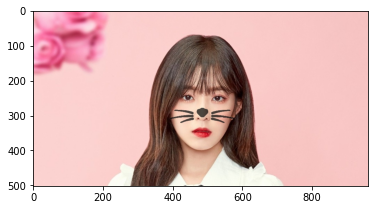

In [7]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.3, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.7, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()